Этот ноутбук содержит реализацию метода Шепли-Сноу для некоторых задач из области игр поиска.

Метод Шепли-Сноу используется для нахождения оптимальных стратегий и значения игры в прямоугольных играх (антагонистических играх размера $n \times m$). Поскольку рассматриваемые игры поиска как раз относятся к играм такого типа, данный метод подходит здесь идеально.

Задача, решённая в данном ноутбуке, может быть сформулирована следующим образом.

Пусть у нас есть два игрока — $H$ и $S$, один объект и $n$ ячеек, куда этот объект можно положить. Игрок $H$ прячет этот объект в одну из $n$ ячеек, а игрок $S$ пытается за $m$ попыток его найти. Вероятность найти объект в ячейке, если он там содержится, не 100%-ая и зависит от ячейки, в которой объект спрятан. Игрок $S$ может смотреть в одну и ту же ячейку дважды.

Цель игрока $H$ — спрятать объект в такую ячейку, чтобы вероятность обнаружения объекта игроком $S$ была минимальна.

Цель игрока $S$ — найти объект или максимально (с точки зрения вероятности обнаружения) приблизиться к этому.

Данная игра, как и любая матричная игра, может быть представлена в виде матрицы игры — таблицы, где строки отвечают за стратегии одного игрока ($S$ в данном случае), а столбцы — за стратегии другого игрока (соответственно, $H$).

На пересечении $i$-ой строки и $j$-ого столбца, в ячейке $(i, j)$ матрицы игры, находится выигрыш (проигрыш) игрока $S$ (игрока $H$) — вероятность того, что игрок $S$ найдёт объект в данной ячейке.

Ниже находится необходимые для работы данного ноутбука технические детали — импорты, реализация необходимых функций (построение матрицы игры, сам метод Шепли-Сноу и пр.). После этого будет представлен относительно дружелюбный интерфейс для взаимодействия с ноутбуком, где пользователю будет предложено ввести необходимые входные параметры, после чего он получит результат — матрицу игры, оптимальные стратегии и значение игры для данного входа.

Наконец отметим, что если алгоритм вывел несколько пар оптимальных стратегий, то их следует воспринимать как крайние точки симплекса, все значения которого являются парами оптимальных стратегий.

Необходимые импорты:

In [1]:
# !jupyter nbextension enable --py widgetsnbextension
import numpy as np
from math import comb
from itertools import combinations, compress
import pandas as pd
from tqdm.notebook import tqdm, trange
import time
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, CheckButtons
%matplotlib notebook
from ipywidgets import *

Используемые функции:

In [2]:
# finding nonnegative integers p1, p2, ..., pn such that p1 + p2 + ... + pn = m

# m should be a nonnegative integer
# n should be a positive integer
# remainder should ALWAYS be an empty list (except for internal recursive function calls)

# return all possible composition of m into n parts as a list of lists

def get_all_compositions(m, n, remainder = []):
    if n < 1:
        raise ValueError("n must be positive integer!")
    elif n == 1:
        return [remainder + [m]]
    else:
        answer = []
        for i in range(m, -1, -1):
            answer += get_all_compositions(m-i, n-1, remainder+[i])
    return answer

In [3]:
# finding a payoff matrix for our task

# n should be a positive integer
# m should be a positive integer
# p should be a list of floats of length n:
# ....for each i p[i] should be greater than 0 and less than 1
# eps is an optional argument which is used to compare two floats:
# ....two floats a and b are considered equal only if abs(a - b) < eps

# return the payoff matrix as a numpy.array and a list of row labels:
# ....each row label is a list in format {a1, a2, ..., an} where
# ....each ai is a nonnegative integer, a1+...+an = m and
# ....each ai means number of tries to search in i-th cell

def get_game_matrix(n, m, p, eps=1e-6):
    if not isinstance(n, int) or n < 1:
        raise ValueError(f"n must be positive integer, but was {type(n)}!")
    if not isinstance(m, int) or m < 1:
        raise ValueError(f"m must be positive integer, but was {type(m)}!")
    if len(p) != n:
        raise ValueError(f"Size of p must be equal to n, but was {len(p)}!")
    for i in range(n):
        if p[i] < eps or p[i] > 1 - eps:
            raise ValueError(f"Probability must be between 0 and 1 (ends are not included), but was {p[i]}")
    
    X = np.tile(np.array(p), (comb(m+n-1, m), 1))
    strategies = get_all_compositions(m, n)

    # contains following values: [p, p(1+q), p(1+q+q^2), ..., p(1+q+...+q^m)] 
    prob_list = [x * np.cumsum(np.cumprod(np.insert(np.repeat(1 - x, m - 1), 0, 1))) for x in p]
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = prob_list[j][strategies[i][j] - 1] if strategies[i][j] > 0 else 0
    return X, strategies

In [4]:
# finding an adjugate matrix for a given square matrix

# matrix should be a numpy.array with two equal dimensions
# det is an optional argument which can be used to avoid
# ....computing a matrix determinant once more

# return the adjugate matrix of a given one as a numpy.array

def get_adjugate_matrix(matrix, det=None):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix should be square for computing its adjugate matrix!")
    
    if det is None:
        det = np.lonalg.det(matrix)
    if det != 0:
        C = np.linalg.inv(matrix) * det
    else :
        C = np.zeros(matrix.shape)
        nrows, ncols = C.shape
        for row in range(nrows):
            sign_factor = -1 if row % 2 == 1 else 1
            for col in range(ncols):
                minor = np.delete(np.delete(matrix, row, 0), col, 1)
                C[row][col] = sign_factor * np.linalg.det(minor)
                sign_factor = -sign_factor
    return C

In [5]:
def group_equal(arr):
    groups = []
    for i in range(len(arr)):
        for j in range(i + 1, len(arr)):
            if arr[i] == arr[j]:
                if not groups:
                    groups.append([i, j])
                    continue
                found = False
                for g in groups:
                    if i in g:
                        if not j in g:
                            g.append(j)
                        found = True
                        break
                if not found:
                    groups.append([i, j])
    return groups

In [6]:
def find_equilibrium(_X, _strategies=[], probabilities=[], modded=True, detailed_feedback=False, eps=1e-6, disable=False):
    total_counter = 0
    answer_x = []
    answer_y = []
    answer_value = None
    
    X = None
    strategies = None
    
    if not modded:
        X = _X
        strategies = _strategies
    else:
        grouped_probs = group_equal(probabilities)
    
        # Each strategy has its label {a1, a2, ..., an} where ai means number of tries to search in i-th cell
        # if p[i] == p[j] then strategy is acceptable only if abs(ai - aj) <= 1 or 2 (it depends on how much
        # we throw away)
        def is_acceptable_strategy(strategy, week_condition=False):
            acceptable_strategy = True
            for group in grouped_probs:
                for j in range(len(group)):
                    for k in range(j, len(group)):
                        if abs(strategy[group[j]] - strategy[group[k]]) > (1 if not week_condition else 2):
                            acceptable_strategy = False
                            break
                    if not acceptable_strategy:
                        break
                if not acceptable_strategy:
                    break
            return acceptable_strategy

        acceptable_strategies_mask = [is_acceptable_strategy(strategy) for strategy in _strategies]
        if sum(acceptable_strategies_mask) < _X.shape[1]:
            acceptable_strategies_mask = [is_acceptable_strategy(strategy, True) for strategy in _strategies]
            if sum(acceptable_strategies_mask) < _X.shape[1]:
                if detailed_feedback:
                    print(f"New matrix consists only {sum(acceptable_strategies_mask)} rows. Using the old one.")
                X = _X
                strategies = _strategies
            else:
                X = _X[acceptable_strategies_mask]    
                strategies = list(compress(_strategies, acceptable_strategies_mask))
        else:
            X = _X[acceptable_strategies_mask]    
            strategies = list(compress(_strategies, acceptable_strategies_mask))
    
    if detailed_feedback:
        print_game_matrix(X, strategies)
    
    # Choose sq_matrix_size rows from modded_X.shape[0] possible
    min_size = 1
    if modded:
        min_size = X.shape[1]
    for sq_matrix_size in trange(min_size, X.shape[1] + 1, disable=disable):
        for row_idxs in tqdm(combinations(range(X.shape[0]), sq_matrix_size), total=comb(X.shape[0], sq_matrix_size), disable=disable):
            total_counter += 1

            try:
                rows = [np.array(strategies[i]) for i in row_idxs]
                if modded:
                    is_acceptable_set = True
                    for i in range(len(rows)):
                        for j in range(i + 1, len(rows)):
                            diff = abs(rows[i] - rows[j])
                            if any(e > 1 for e in abs(rows[i] - rows[j])):
                                is_acceptable_set = False
                                break
                        if not is_acceptable_set:
                            break
                    if not is_acceptable_set:
                        continue

                _row_idxs = []
                j = 0
                for i in range(len(_strategies)):
                    if _strategies[i] == strategies[row_idxs[j]]:
                        _row_idxs.append(i)
                        j += 1
                        if j == len(row_idxs):
                            break

                B = X[row_idxs, :]

                if detailed_feedback:
                    print(f"Case #{total_counter}")
                    print(f"Square submatrix for rows {['{' + ', '.join(str(e) for e in x) + '}' for x in rows]}:")
                    # print(B)

                J = np.ones((1, X.shape[1]))
                detB = np.linalg.det(B)
                adjB = get_adjugate_matrix(B, detB)
                xnom = J.dot(adjB)
                denom = xnom.dot(J.transpose())[0][0]
                if abs(denom) < eps:
                    raise Exception("Denominator is zero!")
                xnom = xnom[0]
                ynom = J.dot(adjB.transpose())[0]
                x = np.zeros(_X.shape[0])
                x[_row_idxs] = xnom / denom
                y = ynom / denom
                v = detB / denom
                if np.any((x < -eps)) or np.any((y < -eps)):
                    raise Exception("Some of probabilities are negative! ")

                for j in range(_X.shape[1]):
                    expectation = 0
                    for k in range(len(x)):
                        expectation += x[k] * _X[k][j]
                    if (expectation > v + eps and y[j] > eps or expectation < v - eps or
                            y[j] > eps and abs(expectation - v) > eps):
                        raise Exception(f"Check failed! E(x, {j + 1}) = {rounder(expectation)} < v = {rounder(v)}")
                for k in range(_X.shape[0]):
                    expectation = 0
                    for j in range(len(y)):
                        expectation += y[j] * _X[k][j]
                    if (expectation < v - eps and x[k] > eps or expectation > v + eps or
                            x[k] > eps and abs(expectation - v) > eps):
                        raise Exception(f"Check failed! E({'{' + ', '.join(str(e) for e in strategies[k]) + '}'}, y) "
                                        f"= {rounder(expectation)} > v = {rounder(v)}")


                if not answer_value:
                    answer_value = v
                elif abs(answer_value - v) > eps:
                    raise RuntimeError("Game values are different for different pair of strategies!")

                if detailed_feedback:
                    print("Got answer!")
                    print(f"x = {rounder(xnom/denom)}")
                    print(f"y = {rounder(y)}")
                    print()
                    print()

                to_add = True
                for _x in answer_x:
                    if np.allclose(x, _x):
                        to_add = False
                        break
                if to_add:
                    answer_x.append(x)

                to_add = True
                for _y in answer_y:
                    if np.allclose(y, _y):
                        to_add = False
                        break
                if to_add:
                    answer_y.append(y)

            except Exception as e:
                if detailed_feedback:
                    print(e)
                    if abs(denom) > eps:
                        print(f"x = {rounder(xnom/denom)}")
                        print(f"y = {rounder(y)}")
                    print()
                    print()
    
    return answer_value, answer_x, answer_y

In [7]:
def ordinal(n):
    return "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

In [8]:
def check_equality(a, b):
    if len(a) != len(b):
        return False
    return all(np.allclose(x, y) for x, y in zip(a, b))

In [9]:
def rounder(a, prec = 5):
    if isinstance(a, int) or isinstance(a, float):
        return round(a, prec)
    elif isinstance(a, list) or isinstance(a, np.ndarray):
        return [round(k, prec) for k in a]
    else:
        raise Exception(f"Unexpected argument for rounder function: {a} of type {type(a)}")

In [10]:
def print_game_matrix(X, strategies, detailed_labels=True):
    rows = ['{' + ', '.join(str(e) for e in x) + '}' for x in strategies]
    columns = [ordinal(x) for x in range(1, X.shape[1] + 1)]
    
    if detailed_labels:
        rows = [x + " times" for x in rows]
        columns = [y + " cells" for y in columns]
    
    df = pd.DataFrame(np.vectorize(rounder)(X), index=rows, columns=columns)
    print("Matrix of game:")
    display(df)
    print()

In [11]:
def print_optimal_strategies(x, y, rows, columns):
    dfx = pd.DataFrame(np.array(rounder(x)).reshape(1, -1), columns=rows, index=['x'])
    dfy = pd.DataFrame(np.array(rounder(y)).reshape(1, -1), columns=columns, index=['y'])
    display(dfx.loc[:, [not (dfx[e] == 0).all() for e in dfx.columns]])
    display(dfy.loc[:, [not (dfy[e] == 0).all() for e in dfy.columns]])

In [12]:
def print_result(v, x, y, strategies):
    print(f"Value of the game is {rounder(value)}.")
    print()
    
    print("Optimal strategies of player S (only non-zero values!):")
    columns = ['{' + ', '.join(str(e) for e in x) + '}' for x in strategies]
    counter = 0
    for s in x:
        counter += 1
        dfx = pd.DataFrame(np.array(rounder(s)).reshape(1, -1), columns=columns, index=[f'x{counter}'])
        display(dfx.loc[:, [not (dfx[e] == 0).all() for e in dfx.columns]])
    print()
    
    print("Optimal strategies of player H (only non-zero values!):")
    columns = [ordinal(x) for x in range(1, X.shape[1] + 1)]
    counter = 0
    for s in y:
        counter += 1
        dfy = pd.DataFrame(np.array(rounder(s)).reshape(1, -1), columns=columns, index=[f'y{counter}'])
        display(dfy.loc[:, [not (dfy[e] == 0).all() for e in dfy.columns]])

Параметры, используемые в методе:

$n$ — количество ячеек всего, $n \in \mathbb N$;

$m$ — количество ячеек, которые может осмотреть игрок $S$, $m \in \mathbb N$;

$p = (p_1, ..., p_n)$ — вероятности найти объект в соответствующих ячейках, $p_i \in (0; 1)$.

Введите входные данные ниже:

In [44]:
n = 2
m = 4
p = [0.2, 0.2]
modded = True
detailed_feedback = False
eps = 1e-6

Матрица игры, оптимальные стратегии и соответствующее им значение игры:

In [45]:
value = 0
x = []
y = []

try:
    X, strategies = get_game_matrix(n, m, p)
    print_game_matrix(X, strategies)
    value, x, y = find_equilibrium(X, strategies, p, modded=modded, detailed_feedback=detailed_feedback, eps=eps)
    print_result(value, x, y, strategies)
except Exception as e:
    print(f"Error! {e}")

Matrix of game:


,1st cells,2nd cells
"{4, 0} times",0.5904,0.0000
"{3, 1} times",0.4880,0.2000
"{2, 2} times",0.3600,0.3600
"{1, 3} times",0.2000,0.4880
"{0, 4} times",0.0000,0.5904


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Value of the game is 0.36.

Optimal strategies of player S (only non-zero values!):


,"{2, 2}"
x1,1.0



Optimal strategies of player H (only non-zero values!):


,1st,2nd
y1,0.55556,0.44444


,1st,2nd
y2,0.44444,0.55556


Тестирование модификаций алгоритма — совпадает ли ответ с немодифицированной версией:

In [ ]:
eps = 1e-6

v1 = v2 = None
x1 = x2 = []
y1 = y2 = []

nmin = 1
nmax = 3
mmin = 1
mmax = nmax * 2 + 1
pstep = 0.1
pstep_int = int((1.-pstep)/pstep)
pmin = pstep
pmax = 1.0 - pstep

for n in trange(nmin, nmax + 1):
    p = np.full(n, pmin)
    for l in trange(1, pstep_int ** n + 1):
        for m in range(mmin, mmax + 1):
            X, strategies = get_game_matrix(n, m, p)
            # v1, x1, y1 = find_equilibrium(X, strategies, p, modded=False, disable=True)
            v2, x2, y2 = find_equilibrium(X, strategies, p, modded=True, disable=True)
            if n > 2 and len(y2) != 1 and np.min(p) != np.max(p):
                print(f"n = {n}, p = {rounder(p)}, m = {m}, len = {len(y2)}")
                # print("Results:")
                # print_result(v2, x2, y2, strategies)
                # print("\n===================\n\n")
            '''
            if v1 != v2 or not check_equality(x1, x2) or not check_equality(y1, y2):
                print(f"n = {n}, p = {rounder(p)}, m = {m}\nUnmodded results:")
                print_result(v1, x1, y1, strategies)
                print("\nModded results:")
                print_result(v2, x2, y2, strategies)
                print("\n===================\n\n")
            '''
        p[n - 1] += pstep
        for i in range(1, n):
            if l % (pstep_int ** i) == 0:
                p[n - i] = pmin
                p[n - 1 - i] += pstep

Графики:

In [13]:
def get_answer_by_input_data(n, m, p):
    X, strategies = get_game_matrix(n, m, p)
    return find_equilibrium(X, strategies, p, disable=True)

In [37]:
pstep = 0.01
pmin = pstep
pmax = 1. - pstep
pn = int(1./pstep) - 1

n = 2
m = 5

answers_v = np.zeros((pn, pn))
answers_x = np.zeros((m + 1, pn, pn))
answers_y_min = np.zeros((n, pn, pn))
answers_y_max = np.zeros((n, pn, pn))

try:
    p1 = pmin
    for i in trange(pn):
        p2 = pmin
        for j in range(pn):
            v, x, y = get_answer_by_input_data(n, m, [p1, p2])
            answers_v[i][j] = v
            for k in range(m + 1):
                answers_x[k][i][j] = x[0][k]
            for k in range(n):
                if len(y) == n:
                    answers_y_min[k][i][j] = min(y[0][k], y[1][k])
                    answers_y_max[k][i][j] = max(y[0][k], y[1][k])
                else:
                    answers_y_min[k][i][j] = y[0][k]
                    answers_y_max[k][i][j] = y[0][k]
            p2 += pstep
        p1 += pstep
except IndexError as e:
    print(f"Error!")

  0%|          | 0/99 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


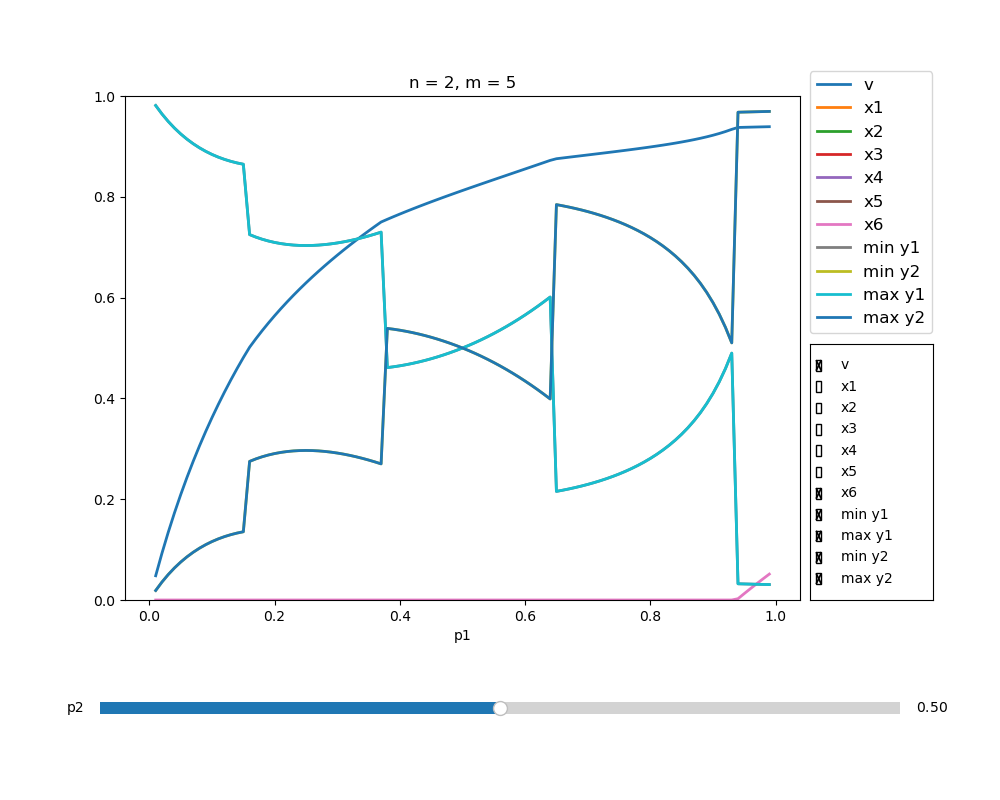

In [38]:
p1 = np.linspace(pmin, pmax, pn)

# Define initial parameters
init_p2 = 0.5

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
idx = int((pn+1)*init_p2-1)
v_line = plt.plot(p1, answers_v[:, idx], lw=2, label="v")
x_lines = [plt.plot(p1, answers_x[i, :, idx], lw=2, label=f"x{i+1}") for i in range(m + 1)]
y_min_lines = [plt.plot(p1, answers_y_min[i, :, idx], lw=2, label=f"min y{i+1}") for i in range(n)]
y_max_lines = [plt.plot(p1, answers_y_max[i, :, idx], lw=2, label=f"max y{i+1}") for i in range(n)]

idxs = [i for i in range(n)]
for i in range(n):
    idxs.insert(n - i, 2 * n - 1 - i)
lines = [v_line] + x_lines + [(y_min_lines + y_max_lines)[i] for i in idxs]
ax.set_xlabel('p1')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(right=0.8, bottom=0.25)
plt.ylim([0, 1])
plt.title(f"n = {n}, m = {m}")
fig.set_size_inches(10, 8)

# Make a horizontal slider to control the frequency.
axp2 = plt.axes([0.1, 0.1, 0.8, 0.03])
p2_slider = Slider(
    ax=axp2,
    label='p2',
    valmin=pmin,
    valmax=pmax,
    valinit=init_p2,
    valstep=pstep,
)

# The function to be called anytime a slider's value changes
def update(val):
    idx = int((pn+1)*p2_slider.val-1)
    lines[0][0].set_ydata(answers_v[:, idx])
    for i in range(1, m + 2):
        lines[i][0].set_ydata(answers_x[i-1, :, idx])
    for i in range(m + 2, m + 2 + 2 * n, 2):
        lines[i][0].set_ydata(answers_y_min[int((i-m-2)/2), :, idx])
        lines[i + 1][0].set_ydata(answers_y_max[int((i-m-2)/2), :, idx])
        
    fig.canvas.draw_idle()

# register the update function with each slider
p2_slider.on_changed(update)

rax = plt.axes([0.81, 0.25, 0.123, 0.32])
labels = [str(line[0].get_label()) for line in lines]
visibility = [line[0].get_visible() for line in lines]
check = CheckButtons(rax, labels, visibility)

def func(label):
    index = labels.index(label)
    lines[index][0].set_visible(not lines[index][0].get_visible())
    plt.draw()

check.on_clicked(func)

ax.legend(loc=(1.015, 0.53), prop={'size': 12})

plt.show()
